In [291]:
# Beckham Carver
# Last modified: 7/29/2024
# Algorithim Selection

US Census Bureau
https://www.kaggle.com/code/sukanto/inclusive-and-safe-spaces/input
https://www.unitedstateszipcodes.org/zip-code-database/population/
https://saturncloud.io/blog/how-to-split-text-in-a-column-into-multiple-rows-using-pandas/
https://stackoverflow.com/questions/38829702/summing-booleans-in-a-dataframe
https://stackoverflow.com/questions/32059397/pandas-groupby-without-turning-grouped-by-column-into-index
https://stackoverflow.com/questions/47040728/get-average-difference-between-all-numbers-in-a-list-python

In [292]:
import pandas as pd
import numpy as np
import sklearn
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [293]:
df = pd.read_csv('rawdata/pride-ranking-dataset/pride_index.csv')
dfz = pd.read_csv('rawdata/zip_code_database.csv')
dfi = pd.read_csv('rawdata/ACSST5Y2020.S1901-Data.csv',header=1)

In [294]:
dfz = dfz.filter(['zip', 'irs_estimated_population','primary_city', 'state'])
dfz['irs_estimated_population'] = dfz['irs_estimated_population'].astype('int64')

dfz['irs_estimated_population'] = dfz.groupby(['zip'])['irs_estimated_population'].agg('sum')
dfz.drop_duplicates(subset=['zip'], keep='first', inplace=True)

dfz.dropna(inplace=True)
dfz.rename(columns={'zip':'Zipcode'}, inplace=True)
dfz = dfz[dfz['irs_estimated_population'] != 0]

dfz['campus_location'] = dfz['primary_city'] + ', ' + dfz['state']
tmp = dfz.groupby('campus_location').agg({
    'irs_estimated_population' : lambda x: x.sum(),
    'state' : lambda x: x.iloc[0]
})

dfz = pd.merge(dfz, tmp, on=['campus_location'], how='outer', indicator=True)
dfz = dfz.loc[dfz['_merge'] == 'both'].drop('_merge', axis=1)
dfz.rename(columns={'irs_estimated_population_y' : 'irs_estimated_population', 'state_x' : 'state'}, inplace=True)
dfz = dfz[dfz['state_y'] == dfz['state']]

dfz.drop(columns=['irs_estimated_population_x', 'state_y'], inplace=True)
print(dfz.describe().T)
dfz

                            count          mean            std     min  \
Zipcode                   16291.0  52132.608680   26781.509339  1830.0   
irs_estimated_population  16291.0  67706.231048  194915.460901     9.0   

                              25%      50%      75%        max  
Zipcode                   30367.0  53290.0  74448.5    99929.0  
irs_estimated_population    950.0   6110.0  31374.5  1466452.0  


,Zipcode,primary_city,state,campus_location,irs_estimated_population
0,38601,Abbeville,MS,"Abbeville, MS",210.0
1,29620,Abbeville,SC,"Abbeville, SC",408.0
2,4406,Abbot,ME,"Abbot, ME",11310.0
3,21005,Aberdeen Proving Ground,MD,"Aberdeen Proving Ground, MD",129.0
4,21001,Aberdeen,MD,"Aberdeen, MD",5040.0
...,...,...,...,...,...
16286,33890,Zolfo Springs,FL,"Zolfo Springs, FL",359.0
16287,59546,Zortman,MT,"Zortman, MT",2770.0
16288,23898,Zuni,VA,"Zuni, VA",22180.0
16289,59547,Zurich,MT,"Zurich, MT",300.0


In [295]:
dfi = dfi.filter(['Geographic Area Name','Estimate!!Households!!Median income (dollars)','Estimate!!Households!!Total', 'Estimate!!Households!!Mean income (dollars)', 'Estimate!!Nonfamily households!!Total', 'Estimate!!Married-couple families!!Total', 'Estimate!!Families!!Total'])
dfi.rename(columns={'Estimate!!Households!!Median income (dollars)':'Median Household Income'}, inplace=True)
dfi.rename(columns={'Estimate!!Households!!Total':'Total Households'}, inplace=True)
dfi.rename(columns={'Estimate!!Households!!Mean income (dollars)':'Mean Household Income'}, inplace=True)
dfi.rename(columns={'Estimate!!Married-couple families!!Total':'Married-couple Family households'}, inplace=True)
dfi.rename(columns={'Estimate!!Nonfamily households!!Total':'Non-family households'}, inplace=True)
dfi.rename(columns={'Estimate!!Families!!Total':'Family households'}, inplace=True)
dfi.rename(columns={'Geographic Area Name':'Zipcode'}, inplace=True)

dfi.drop_duplicates(subset=['Zipcode'], keep='first')
dfi.dropna(inplace=True)

dfi['Zipcode'] = dfi['Zipcode'].apply(lambda x : x.removeprefix('ZCTA5 '))
dfi['Mean Household Income'] = dfi['Mean Household Income'].transform(lambda x: 0 if pd.isna(x) or pd.isnull(x) or x == 'N' or x == '-' else x.replace('2,500-', '1250').replace('250,000+', str(random.randrange(250000,1000000, 500)))) # crude rounding
dfi['Median Household Income'] = dfi['Median Household Income'].transform(lambda x: 0 if pd.isna(x) or pd.isnull(x) or x == 'N' or x == '-' else x.replace('2,500-', '1250').replace('250,000+', str(random.randrange(250000,1000000, 500)))) # crude rounding

dfi['Zipcode'] = dfi['Zipcode'].astype('int64')
dfi['Total Households'] = dfi['Total Households'].astype('int64')
dfi['Median Household Income'] = dfi['Median Household Income'].astype('int64')
dfi['Mean Household Income'] = dfi['Mean Household Income'].astype('int64')
dfi['Married-couple Family households'] = dfi['Married-couple Family households'].astype('int64')
dfi['Non-family households'] = dfi['Non-family households'].astype('int64')
dfi['Family households'] = dfi['Family households'].astype('int64')


print(dfi.describe().T)
dfi

                                    count          mean           std    min  \
Zipcode                           33120.0  49666.334209  27564.925769  601.0   
Median Household Income           33120.0  58889.002204  35520.300878    0.0   
Total Households                  33120.0   3730.548490   5396.181697    0.0   
Mean Household Income             33120.0  76852.308364  39159.095947    0.0   
Non-family households             33120.0   1295.245169   2082.018837    0.0   
Married-couple Family households  33120.0   1789.100936   2599.966975    0.0   
Family households                 33120.0   2435.303321   3544.793351    0.0   

                                       25%      50%       75%       max  
Zipcode                           26634.75  49739.0  72123.50   99929.0  
Median Household Income           42832.75  55873.5  72223.00  987500.0  
Total Households                    272.00   1081.0   5118.75   41335.0  
Mean Household Income             56908.50  70582.5  89517.50  

,Zipcode,Median Household Income,Total Households,Mean Household Income,Non-family households,Married-couple Family households,Family households
0,601,14398,5555,19353,1643,2354,3912
1,602,16771,12901,26150,3707,5933,9194
2,603,15786,19431,27451,6263,6942,13168
3,606,14980,1983,18534,632,591,1351
4,610,20167,8864,27865,2559,3884,6305
...,...,...,...,...,...,...,...
33115,99923,0,12,0,12,0,0
33116,99925,63125,365,77633,148,155,217
33117,99926,58000,440,69587,92,239,348
33118,99927,0,0,0,0,0,0


In [296]:
dfi = pd.merge(dfi, dfz, on=['Zipcode'], how='outer', indicator=True)
dfi = dfi.loc[dfi['_merge'] == 'both'].drop('_merge', axis=1)

df = pd.merge(df, dfi, on=['campus_location'], how='inner', indicator=True)
df = df.loc[df['_merge'] == 'both'].drop('_merge', axis=1)
df



,campus_name,campus_location,rating,students,community_type,Zipcode,Median Household Income,Total Households,Mean Household Income,Non-family households,Married-couple Family households,Family households,primary_city,state,irs_estimated_population
0,"University of Maryland, College Park","College Park, MD",5.0,37952,large urban city,20740,73315.0,9789.0,96091.0,5273.0,3412.0,4516.0,College Park,MD,23770.0
1,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city,48124,72806.0,11888.0,87758.0,4977.0,5331.0,6911.0,Dearborn,MI,85990.0
2,University of Michigan-Dearborn,"Dearborn, MI",3.0,9000,medium city,48128,86198.0,4031.0,95939.0,1232.0,2132.0,2799.0,Dearborn,MI,85990.0
3,SUNY Westchester Community College,"Valhalla, NY",4.0,13000,very small town,10595,104112.0,2347.0,148181.0,762.0,1229.0,1585.0,Valhalla,NY,7900.0
4,University at Buffalo,"Buffalo, NY",3.5,29850,medium city,14201,29814.0,5414.0,48266.0,3326.0,990.0,2088.0,Buffalo,NY,25364.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40513,106195.0,4564.0,142469.0,1248.0,2965.0,3316.0,Lexington,KY,61227.0
952,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40514,85119.0,6041.0,105668.0,1686.0,3631.0,4355.0,Lexington,KY,61227.0
953,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40515,78366.0,14462.0,108170.0,4515.0,7959.0,9947.0,Lexington,KY,61227.0
954,Bluegrass Community & Technical College (BCTC),"Lexington, KY",4.0,14500,medium city,40516,77717.0,1372.0,97094.0,535.0,745.0,837.0,Lexington,KY,61227.0


In [297]:
df = df.copy()
df['median_income*pop'] = df['Median Household Income'] * df['irs_estimated_population']
df = df.groupby('campus_name').agg({
    'campus_location': lambda x: x.iloc[0],
    'state': lambda x: x.iloc[0],
    'community_type': lambda x: x.iloc[0],
    'Zipcode': 'count',  # counting total records in each county
    'rating': lambda x: x.iloc[0],
    'students': lambda x: x.iloc[0],
    'irs_estimated_population' : lambda x: x.sum(),
    'Mean Household Income' : lambda x: x.mean(),
    'median_income*pop' : lambda x: x.to_list(),
    'Total Households' : lambda x: x.sum(),
    'Non-family households' : lambda x: x.sum(),
    'Family households' : lambda x: x.sum(),
    'Married-couple Family households' : lambda x: x.sum()
}).reset_index()
df.rename(columns={'Zipcode' : 'zipcodes'}, inplace=True)
df['Unmarried Family households'] = df['Family households'] - df['Married-couple Family households']
df['Zipcode Income Variance Score'] = df.apply(lambda x: (abs(np.diff(np.array(x['median_income*pop']))).mean() / x['irs_estimated_population']) * 0.0001, axis=1)
df.fillna({'Zipcode Income Variance Score':0}, inplace=True)
df['Household Income Score'] = df.apply(lambda x: (np.mean(x['median_income*pop']) / x['irs_estimated_population']) * 0.0001, axis=1)

df['Ratio Non-Family households'] = df['Non-family households'] / df['Total Households']
df['Ratio Family Households'] = df['Family households'] / df['Total Households']
df['Ratio Married-Family Households'] = df['Married-couple Family households'] / df['Total Households']
df['Ratio Unmarried-Family Households'] = df['Unmarried Family households'] / df['Total Households']

df.drop(columns={'median_income*pop', 'Total Households', 'Family households', 'Non-family households', 'Married-couple Family households', 'Unmarried Family households'}, inplace=True)

df['campus_location'] = df['campus_location'].astype(str)
df['campus_location'] = df['campus_location'].astype('category')
df['state'] = df['state'].astype(str)
df['state'] = df['state'].astype('category')
df['community_type'] = df['community_type'].astype(str)
df['community_type'] = df['community_type'].astype('category')

df

C:\Users\beckcarver\AppData\Local\Temp\ipykernel_8976\3484233043.py:20: RuntimeWarning: Mean of empty slice.
  df['Zipcode Income Variance Score'] = df.apply(lambda x: (abs(np.diff(np.array(x['median_income*pop']))).mean() / x['irs_estimated_population']) * 0.0001, axis=1)
C:\Users\beckcarver\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,campus_name,campus_location,state,community_type,zipcodes,rating,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Ratio Non-Family households,Ratio Family Households,Ratio Married-Family Households,Ratio Unmarried-Family Households
0,Adelphi University,"Garden City, NY",NY,small town,1,5.0,7859,4531.0,230942.000000,0.000000,16.932300,0.200688,0.799312,0.709234,0.090078
1,Art Academy of Cincinnati,"Cincinnati, OH",OH,medium city,3,2.5,260,105243.0,76848.333333,1.249533,1.538656,0.664282,0.335718,0.195527,0.140191
2,Augsburg University,"Minneapolis, MN",MN,large urban city,17,5.0,3537,1622276.0,108819.529412,0.198339,0.479821,0.492180,0.507820,0.401236,0.106584
3,Binghamton University SUNY,"Binghamton, NY",NY,small city,4,4.5,18000,74680.0,49595.750000,0.871758,0.888369,0.476588,0.523412,0.361012,0.162401
4,Bluegrass Community & Technical College (BCTC),"Lexington, KY",KY,medium city,10,4.0,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Whitman College,"Walla Walla, WA",WA,small city,1,3.0,1493,2900.0,78762.000000,0.000000,6.041300,0.370726,0.629274,0.477946,0.151328
117,Wichita State University,"Wichita, KS",KS,large urban city,24,4.0,15000,7988136.0,85387.416667,0.124193,0.286913,0.386725,0.613275,0.439621,0.173654
118,Widener University,"Chester, PA",PA,small city,1,4.0,6300,4195.0,47320.000000,0.000000,3.243100,0.447805,0.552195,0.161639,0.390556
119,Woodbury University,"Burbank, CA",CA,medium city,4,3.0,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267


In [298]:
def convert_comm(val):
    if val == 'large urban city': return 6
    if val == 'medium city': return 5
    if val == 'small city': return 4
    if val == 'small town': return 3
    if val == 'very small town': return 2
    if val == 'rural community': return 1

dfn = df.copy()
dfn['community_type'] = dfn['community_type'].apply(convert_comm)
dfn['community_type'] = dfn['community_type'].astype('int64')
dfn['community_type'] = dfn['community_type'].astype('category')

dfn['state'] = pd.factorize(df['state'])[0]
dfn

,campus_name,campus_location,state,community_type,zipcodes,rating,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Ratio Non-Family households,Ratio Family Households,Ratio Married-Family Households,Ratio Unmarried-Family Households
0,Adelphi University,"Garden City, NY",0,3,1,5.0,7859,4531.0,230942.000000,0.000000,16.932300,0.200688,0.799312,0.709234,0.090078
1,Art Academy of Cincinnati,"Cincinnati, OH",1,5,3,2.5,260,105243.0,76848.333333,1.249533,1.538656,0.664282,0.335718,0.195527,0.140191
2,Augsburg University,"Minneapolis, MN",2,6,17,5.0,3537,1622276.0,108819.529412,0.198339,0.479821,0.492180,0.507820,0.401236,0.106584
3,Binghamton University SUNY,"Binghamton, NY",0,4,4,4.5,18000,74680.0,49595.750000,0.871758,0.888369,0.476588,0.523412,0.361012,0.162401
4,Bluegrass Community & Technical College (BCTC),"Lexington, KY",3,5,10,4.0,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Whitman College,"Walla Walla, WA",14,4,1,3.0,1493,2900.0,78762.000000,0.000000,6.041300,0.370726,0.629274,0.477946,0.151328
117,Wichita State University,"Wichita, KS",11,6,24,4.0,15000,7988136.0,85387.416667,0.124193,0.286913,0.386725,0.613275,0.439621,0.173654
118,Widener University,"Chester, PA",8,4,1,4.0,6300,4195.0,47320.000000,0.000000,3.243100,0.447805,0.552195,0.161639,0.390556
119,Woodbury University,"Burbank, CA",4,5,4,3.0,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267


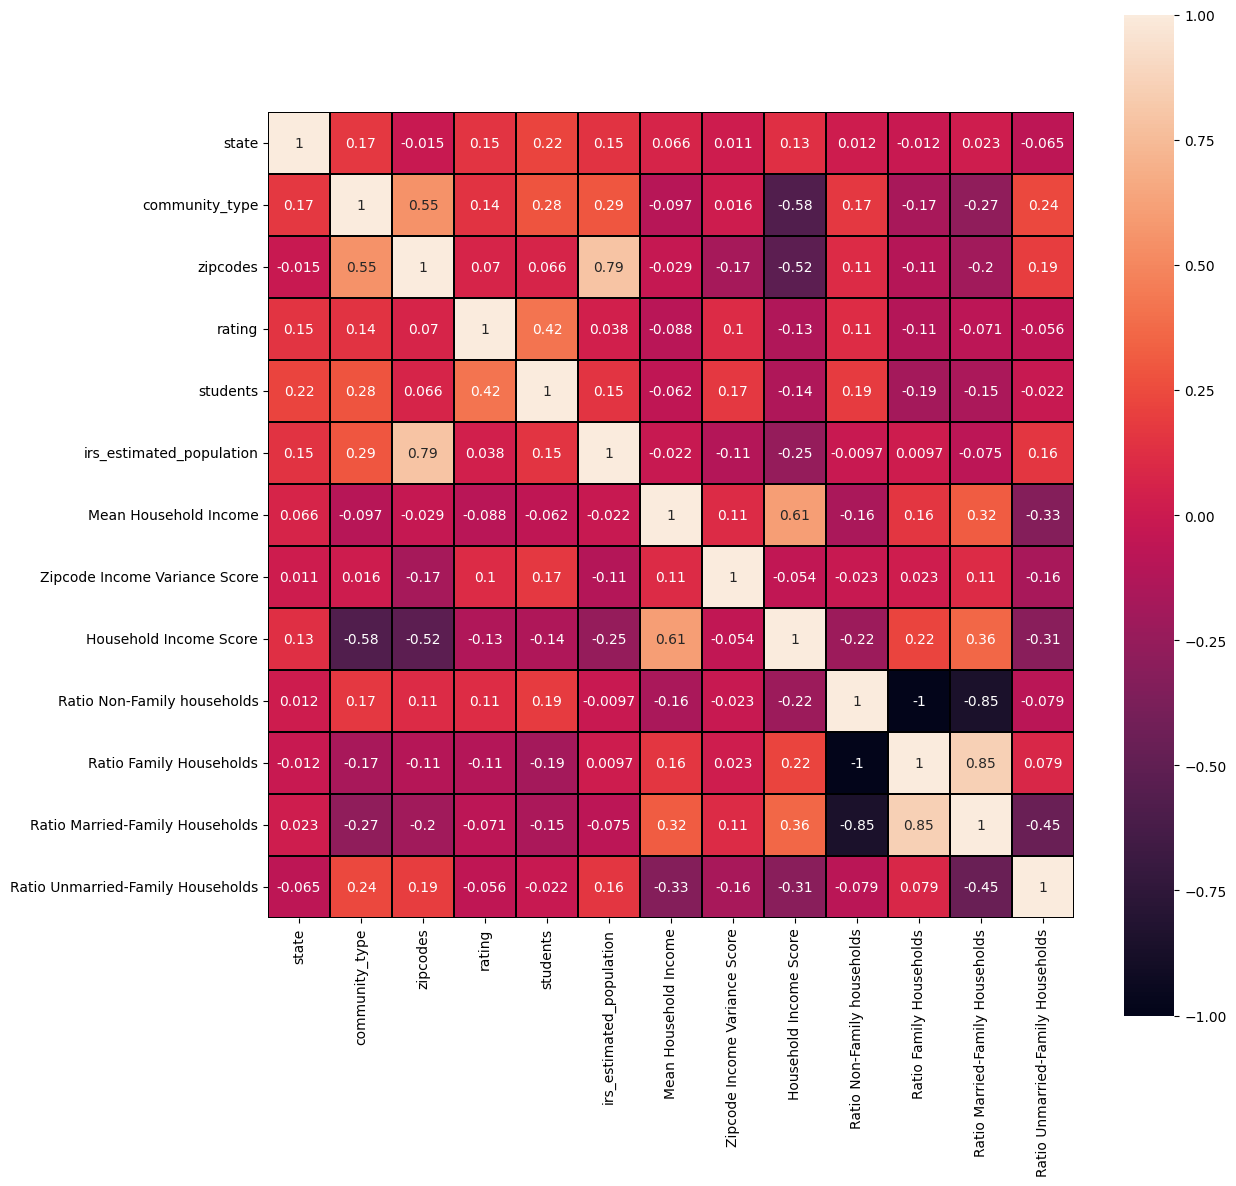

In [299]:
plt.figure(figsize=(13,13))
sns.heatmap(dfn.drop(['campus_name', 'campus_location'], axis=1).corr(), square = True, annot=True, linewidths=.1, linecolor='black')
plt.show()

In [303]:
# as a hail marry, lets bring in all the tags and see what happens
dft = pd.read_csv('rawdata/pride-ranking-dataset/pride_index_tags.csv')
dft = pd.merge(dft, df, on='campus_name', how='inner', indicator=True)
dft.rename(columns={'campus_location_x' : 'campus_location'}, inplace=True)
dft = dft.loc[dft['_merge'] == 'both'].drop('_merge', axis=1)
dft.drop(columns=['campus_location_y', 'hbcu'], inplace=True)
dft['community_type'] = dft['community_type'].apply(convert_comm)
dft['community_type'] = dft['community_type'].astype('int64')
dft['community_type'] = dft['community_type'].astype('category')
dft['state'] = pd.factorize(df['state'])[0]
dft['total_tags'] = dft.select_dtypes(include=['bool']).sum(axis=1)
dft['total_tags'] = dft['total_tags'].astype('int64')

dft

,campus_name,campus_location,public,private,doctoral,masters,baccalaureate,community,residential,nonresidential,...,students,irs_estimated_population,Mean Household Income,Zipcode Income Variance Score,Household Income Score,Ratio Non-Family households,Ratio Family Households,Ratio Married-Family Households,Ratio Unmarried-Family Households,total_tags
0,"University of Maryland, College Park","College Park, MD",True,False,True,False,False,False,True,False,...,37952,23770.0,96091.000000,0.000000,7.331500,0.538666,0.461334,0.348554,0.112780,4
1,University of Michigan-Dearborn,"Dearborn, MI",True,False,True,True,True,False,False,True,...,9000,171980.0,91848.500000,0.669600,3.975100,0.390037,0.609963,0.468811,0.141152,5
2,SUNY Westchester Community College,"Valhalla, NY",True,False,False,False,False,True,False,True,...,13000,7900.0,148181.000000,0.000000,10.411200,0.324670,0.675330,0.523647,0.151683,4
3,University at Buffalo,"Buffalo, NY",True,False,True,True,True,False,True,False,...,29850,50728.0,50574.000000,0.471100,1.726250,0.654806,0.345194,0.160562,0.184631,5
4,Emory University,"Atlanta, GA",False,True,True,False,False,False,True,False,...,14769,4010742.0,113042.411765,0.245479,0.429891,0.548440,0.451560,0.291367,0.160192,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,Woodbury University,"Burbank, CA",False,True,False,True,True,False,True,False,...,1132,153520.0,101182.750000,0.449717,1.866144,0.381058,0.618942,0.450675,0.168267,7
117,University of Texas Arlington,"Arlington, TX",True,False,True,True,True,False,True,False,...,47000,316395.0,79363.600000,0.494205,1.281264,0.307506,0.692494,0.463116,0.229378,8
118,University of Arkansas at Little Rock,"Little Rock, AR",True,False,True,True,True,False,True,True,...,6712,77626.0,157570.000000,0.000000,9.338000,0.346783,0.653217,0.529791,0.123426,7
119,Bluegrass Community & Technical College (BCTC),"Lexington, KY",False,False,False,False,False,True,False,False,...,14500,612270.0,97642.000000,0.278977,0.738196,0.383537,0.616463,0.453357,0.163105,1


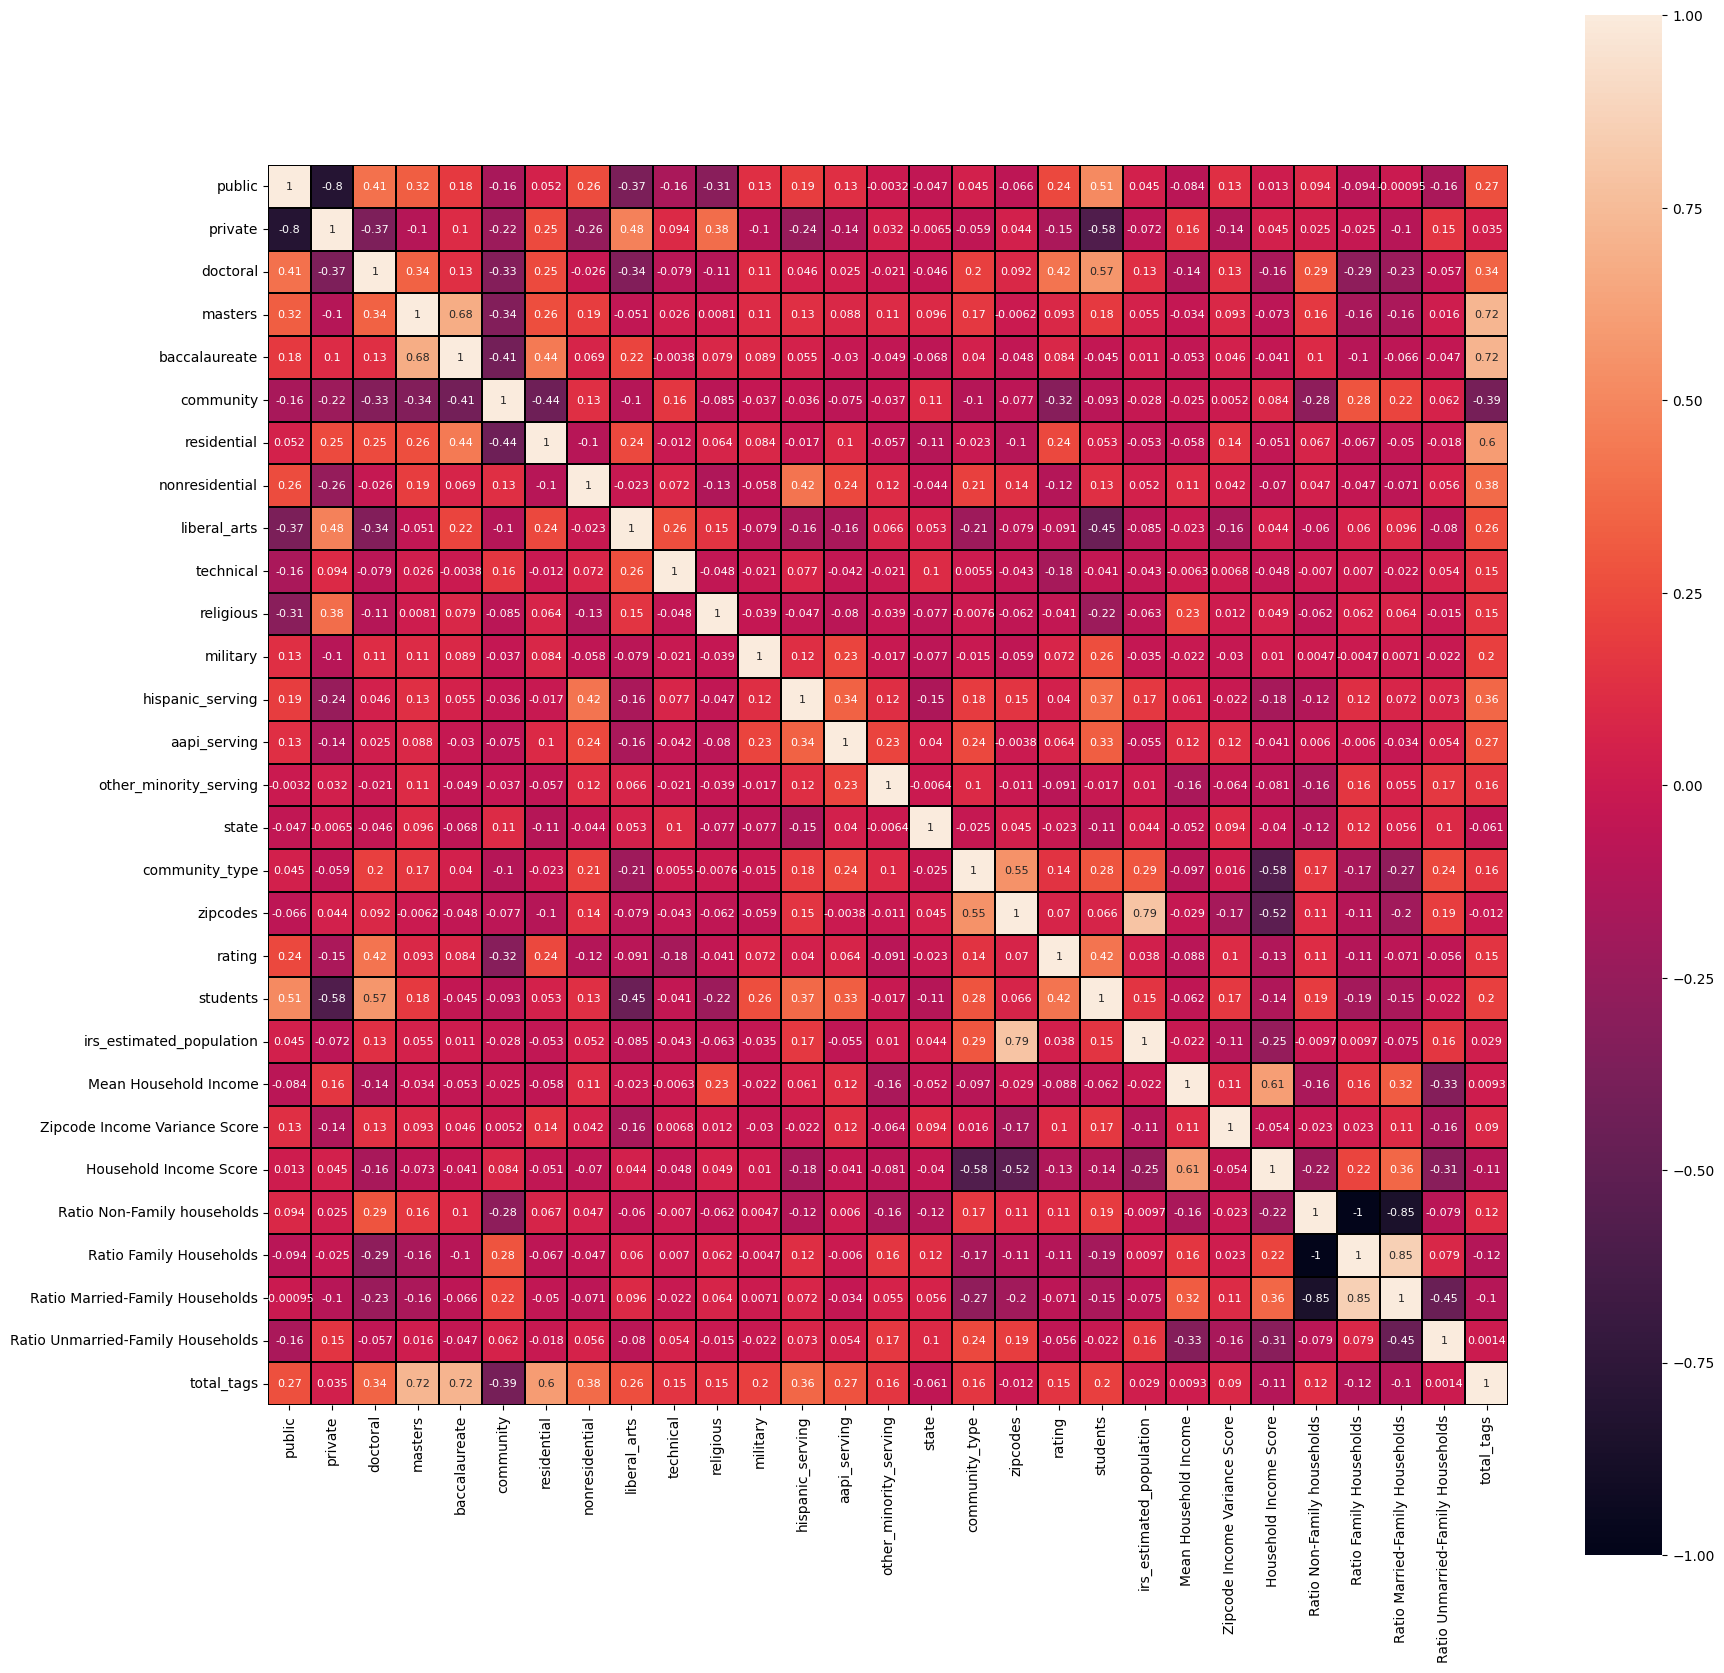

In [304]:
# kitchen sink incomping
plt.figure(figsize=(20, 20))
sns.heatmap(dft.drop(['campus_name', 'campus_location'], axis=1).corr(), square = True, annot=True, linewidths=.1, linecolor='black', annot_kws={'fontsize':8})
plt.show()

# __
There's basically no correlation between ranking and any of the data points. This will be like pulling a rabbit out of a hat fitting a model well to the data, nonetheless I was curious if any unexpected correlations would be found, time to select an algorithim. I'm iffy on whether or not to use the boolean fields. 